In [1]:
import os, sys
import glob
import iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

try:
    import general_io as gio
    import timeseries
except ImportError:
    raise ImportError('Must run this script from anywhere within the ocean-analysis git repo')

In [30]:
pr_files = {}
pr_files[('historical', 'all')] = glob.glob('/g/data/r87/dbi599/CMIP?/CMIP/*/*/historical/*/Ayr/pr/*/*/pr-pe-region-sum-anomaly_Ayr_*-cumsum.nc')
pr_files[('historical', 'CMIP6')] = glob.glob('/g/data/r87/dbi599/CMIP6/CMIP/*/*/historical/*/Ayr/pr/*/*/pr-pe-region-sum-anomaly_Ayr_*-cumsum.nc')
pr_files[('hist-GHG', 'all')] = glob.glob('/g/data/r87/dbi599/CMIP?/DAMIP/*/*/*GHG/*/Ayr/pr/*/*/pr-pe-region-sum-anomaly_Ayr_*-cumsum.nc')
pr_files[('hist-aer', 'all')] = glob.glob('/g/data/r87/dbi599/CMIP?/DAMIP/*/*/*[aer,Misc]/*/Ayr/pr/*/*/pr-pe-region-sum-anomaly_Ayr_*-cumsum.nc')

In [3]:
tasga_files = ['/g/data/r87/dbi599/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Ayr/tas/gn/v20191115/tasga_Ayr_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc',
               '/g/data/r87/dbi599/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ayr/tas/gn/v20190308/tasga_Ayr_CESM2_historical_r1i1p1f1_gn_185001-201412.nc',
               '/g/data/r87/dbi599/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Ayr/tas/gr1/v20190726/tasga_Ayr_GFDL-ESM4_historical_r1i1p1f1_gr1_185001-201412.nc',
               '/g/data/r87/dbi599/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Ayr/tas/gr/v20180803/tasga_Ayr_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc']      

In [17]:
def create_pr_df(file_list, time_bounds):
    """Create pr dataframe"""

    data_dict = {}
    time_constraint = gio.get_time_constraint(time_bounds)
    for pr_file in file_list:
        print(pr_file)
        cube = iris.load_cube(pr_file, 'precipitation_flux')
        cube = gio.check_time_units(cube, new_calendar='365_day')
        cube = cube.extract(time_constraint)
        try:
            model_name = cube.attributes['model_id']
        except KeyError:
            model_name = cube.attributes['source_id']
        if not model_name in ['GISS-E2-R', 'FGOALS-g3']:
            cum_anom = cube[-1, -1, -1].data - cube[0, -1, -1].data
            data_dict[model_name] = cum_anom

    df = pd.DataFrame(data_dict.items(), columns=['Model', 'Change in P'])
    
    return df


def create_tasga_df(file_list, time_bounds):
    """Create tasga dataframe"""

    data_dict = {}
    time_constraint = gio.get_time_constraint(time_bounds)
    for pr_file in file_list:
        cube = iris.load_cube(pr_file, 'air_temperature')
        cube = gio.check_time_units(cube, new_calendar='365_day')
        cube = cube.extract(time_constraint)
        try:
            model_name = cube.attributes['model_id']
        except KeyError:
            model_name = cube.attributes['source_id']
        trend = timeseries.calc_trend(cube, per_yr=True)
        data_dict[model_name] = trend

    df = pd.DataFrame(data_dict.items(), columns=['Model', 'Linear trend (C/yr)'])
    
    return df

In [18]:
df_hist = create_pr_df(pr_files[('historical', 'all')], ['1861-01-01', '2005-12-31'])

/g/data/r87/dbi599/CMIP5/CMIP/LASG-CESS/FGOALS-g2/historical/r1i1p1/Ayr/pr/gn/v1/pr-pe-region-sum-anomaly_Ayr_FGOALS-g2_historical_r1i1p1_gn_185001-201412-cumsum.nc
/g/data/r87/dbi599/CMIP5/CMIP/NCAR/CCSM4/historical/r1i1p1/Ayr/pr/gn/v20160829/pr-pe-region-sum-anomaly_Ayr_CCSM4_historical_r1i1p1_gn_185001-200512-cumsum.nc
/g/data/r87/dbi599/CMIP5/CMIP/NOAA-GFDL/GFDL-CM3/historical/r1i1p1/Ayr/pr/gn/v20120227/pr-pe-region-sum-anomaly_Ayr_GFDL-CM3_historical_r1i1p1_gn_186001-200512-cumsum.nc
/g/data/r87/dbi599/CMIP5/CMIP/NOAA-GFDL/GFDL-ESM2M/historical/r1i1p1/Ayr/pr/gn/v20111228/pr-pe-region-sum-anomaly_Ayr_GFDL-ESM2M_historical_r1i1p1_gn_185001-200512-cumsum.nc
/g/data/r87/dbi599/CMIP5/CMIP/CCCma/CanESM2/historical/r1i1p1/Ayr/pr/gn/v20120718/pr-pe-region-sum-anomaly_Ayr_CanESM2_historical_r1i1p1_gn_185001-200512-cumsum.nc
/g/data/r87/dbi599/CMIP5/CMIP/NCC/NorESM1-M/historical/r1i1p1/Ayr/pr/gn/v20110901/pr-pe-region-sum-anomaly_Ayr_NorESM1-M_historical_r1i1p1_gn_185001-200512-cumsum.nc
/g

In [23]:
df_ghg = create_pr_df(pr_files[('hist-GHG', 'all')], ['1861-01-01', '2005-12-31'])

/g/data/r87/dbi599/CMIP5/DAMIP/LASG-CESS/FGOALS-g2/historicalGHG/r1i1p1/Ayr/pr/gn/v20161204/pr-pe-region-sum-anomaly_Ayr_FGOALS-g2_historicalGHG_r1i1p1_gn_185001-200912-cumsum.nc
/g/data/r87/dbi599/CMIP5/DAMIP/NCAR/CCSM4/historicalGHG/r1i1p1/Ayr/pr/gn/v20120604/pr-pe-region-sum-anomaly_Ayr_CCSM4_historicalGHG_r1i1p1_gn_185001-200512-cumsum.nc
/g/data/r87/dbi599/CMIP5/DAMIP/NOAA-GFDL/GFDL-CM3/historicalGHG/r1i1p1/Ayr/pr/gn/v20120227/pr-pe-region-sum-anomaly_Ayr_GFDL-CM3_historicalGHG_r1i1p1_gn_186001-200512-cumsum.nc
/g/data/r87/dbi599/CMIP5/DAMIP/NOAA-GFDL/GFDL-ESM2M/historicalGHG/r1i1p1/Ayr/pr/gn/v20130214/pr-pe-region-sum-anomaly_Ayr_GFDL-ESM2M_historicalGHG_r1i1p1_gn_185001-200512-cumsum.nc
/g/data/r87/dbi599/CMIP5/DAMIP/CCCma/CanESM2/historicalGHG/r1i1p1/Ayr/pr/gn/v20111027/pr-pe-region-sum-anomaly_Ayr_CanESM2_historicalGHG_r1i1p1_gn_185001-201212-cumsum.nc
/g/data/r87/dbi599/CMIP5/DAMIP/NCC/NorESM1-M/historicalGHG/r1i1p1/Ayr/pr/gn/v20110918/pr-pe-region-sum-anomaly_Ayr_NorESM1-M_h

In [31]:
df_aa = create_pr_df(pr_files[('hist-aer', 'all')], ['1861-01-01', '2005-12-31'])

/g/data/r87/dbi599/CMIP5/DAMIP/LASG-CESS/FGOALS-g2/historicalMisc/r2i1p1/Ayr/pr/gn/v20161204/pr-pe-region-sum-anomaly_Ayr_FGOALS-g2_historicalMisc_r2i1p1_gn_185001-200512-cumsum.nc
/g/data/r87/dbi599/CMIP5/DAMIP/NCAR/CCSM4/historicalMisc/r1i1p10/Ayr/pr/gn/v20120604/pr-pe-region-sum-anomaly_Ayr_CCSM4_historicalMisc_r1i1p10_gn_185001-200512-cumsum.nc
/g/data/r87/dbi599/CMIP5/DAMIP/NOAA-GFDL/GFDL-CM3/historicalMisc/r1i1p1/Ayr/pr/gn/v20120227/pr-pe-region-sum-anomaly_Ayr_GFDL-CM3_historicalMisc_r1i1p1_gn_186001-200512-cumsum.nc
/g/data/r87/dbi599/CMIP5/DAMIP/NOAA-GFDL/GFDL-ESM2M/historicalMisc/r1i1p5/Ayr/pr/gn/v20130214/pr-pe-region-sum-anomaly_Ayr_GFDL-ESM2M_historicalMisc_r1i1p5_gn_185001-200512-cumsum.nc
/g/data/r87/dbi599/CMIP5/DAMIP/CCCma/CanESM2/historicalMisc/r1i1p4/Ayr/pr/gn/v20111028/pr-pe-region-sum-anomaly_Ayr_CanESM2_historicalMisc_r1i1p4_gn_185001-201212-cumsum.nc
/g/data/r87/dbi599/CMIP5/DAMIP/NCC/NorESM1-M/historicalMisc/r1i1p1/Ayr/pr/gn/v20110918/pr-pe-region-sum-anomaly_Ay

In [27]:
def plot_precip(df, experiment):
    """Create precip plot"""

    plt.figure(figsize=(10,5))
    chart = sns.barplot(x="Model", y="Change in P", data=df.sort_values('Model'))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.ylabel('time-integrated anomaly (kg)')
    plt.title(f"Global precipitation (1861-2005), {experiment} experiment")
    plt.show()

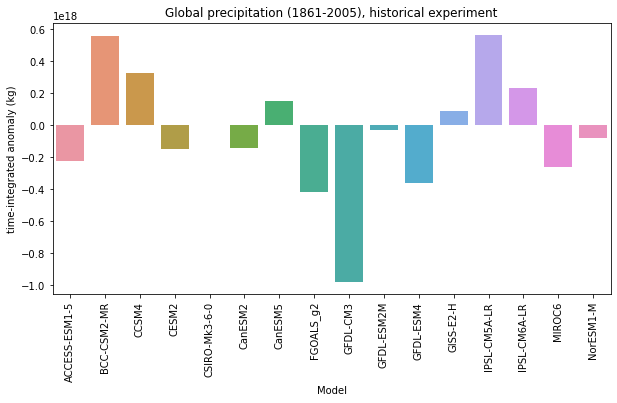

In [28]:
plot_precip(df_hist, 'historical')

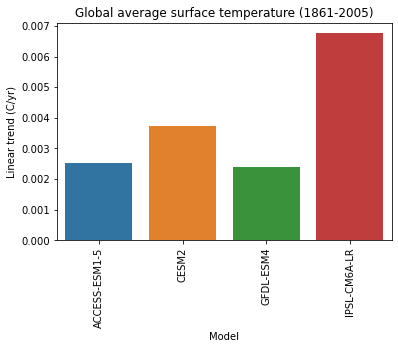

In [11]:
df = create_tasga_df(tasga_files, ['1861-01-01', '2005-12-31'])
plt.figure()
chart = sns.barplot(x="Model", y="Linear trend (C/yr)", data=df.sort_values('Model'))
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Global average surface temperature (1861-2005)')
plt.show()

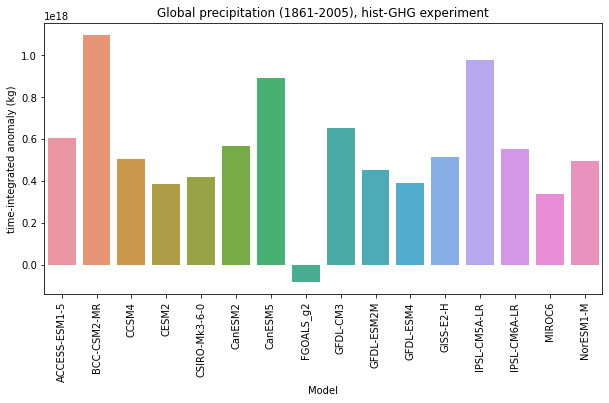

In [29]:
plot_precip(df_ghg, 'hist-GHG')

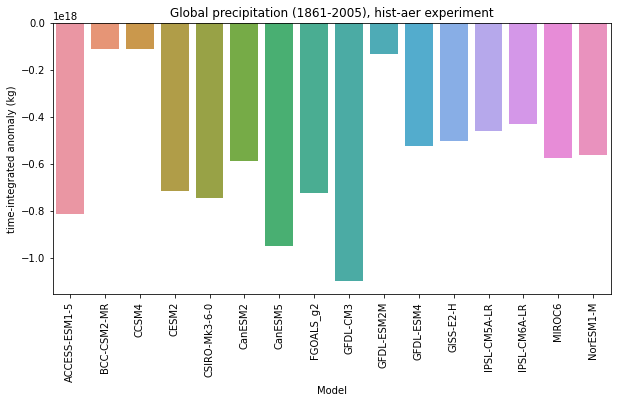

In [32]:
plot_precip(df_aa, 'hist-aer')

In [26]:
df_hist

,Model,Change in P
0,FGOALS_g2,-4.180838e+17
1,CCSM4,3.253760e+17
2,GFDL-CM3,-9.814147e+17
3,GFDL-ESM2M,-2.723476e+16
4,CanESM2,-1.440788e+17
5,NorESM1-M,-8.028425e+16
6,IPSL-CM5A-LR,5.644522e+17
7,GISS-E2-H,8.703470e+16
8,CSIRO-Mk3-6-0,2.095980e+15
9,ACCESS-ESM1-5,-2.270248e+17
